Vincular Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os

# Define la ruta en tu Google Drive donde deseas guardar los resultados
save_path = '/content/drive/MyDrive/SmartRecyclingCNC/yolov8_results_segmetador1_plasticBottles/'

# Crea la carpeta si no existe
if not os.path.exists(save_path):
    os.makedirs(save_path)

Librerias YOLO

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 24.5 MB/s eta 0:00:00


Descargar base de datos roboflow

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="jompa2XSFSWsspM2dsSo")
project = rf.workspace("labs-odu3x").project("plastic-bottles-4bt1x")
version = project.version(1)
dataset = version.download("yolov8")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to plastic-bottles-1 in yolov8:: 100%|██████████| 585/585 [00:00<00:00, 7622.19it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Actualizacion .yaml

In [ ]:
names:
- Bottles
- Lids
nc: 2
path: ../plastic-bottles-1
train: ../train/images
val: ../valid/images
test: ../test/images

Entrenamiento

In [5]:
from ultralytics import YOLO
!yolo task=segment mode=train model=/content/yolov8n-seg.pt data=/content/plastic-bottles-1/data.yaml epochs=720 imgsz=480 patience=90 save_period=90 project=/content/drive/MyDrive/SmartRecyclingCNC/yolov8_results_segmetador1_plasticBottles/ name=train_run profile=True optimizer=AdamW lr0=0.003 batch=-1

100% 6.74M/6.74M [00:00<00:00, 116MB/s]
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=/content/yolov8n-seg.pt, data=/content/plastic-bottles-1/data.yaml, epochs=720, time=None, patience=90, batch=-1, imgsz=480, save=True, save_period=90, cache=False, device=None, workers=8, project=/content/drive/MyDrive/SmartRecyclingCNC/yolov8_results_segmetador1_plasticBottles/, name=train_run, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=True, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_mas

Pruebas


image 1/1 /content/drive/MyDrive/SmartRecyclingCNC/77.jpg: 480x480 1 Bottles, 1 Lids, 7.8ms
Speed: 1.0ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 480)


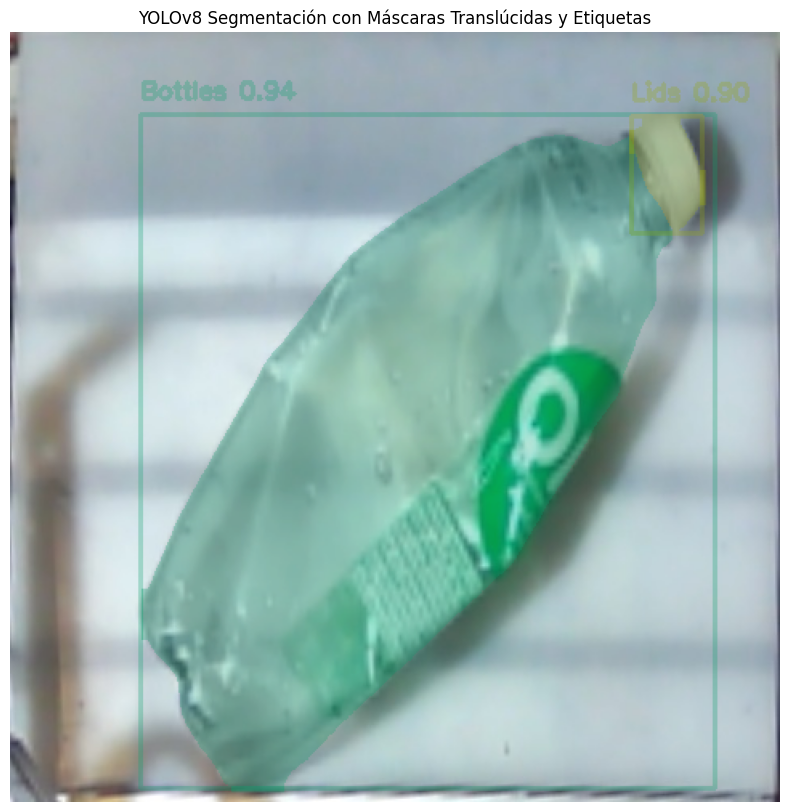

In [8]:
# YOLOv8 Segmentación Básica
# Descripción: Prueba un modelo YOLOv8 segmentador sobre una imagen y muestra resultados.

# Importar las librerías
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Cargar el modelo YOLOv8 segmentador
model = YOLO('/content/drive/MyDrive/SmartRecyclingCNC/yolov8_results_segmetador1_plasticBottles/train_run/weights/best.pt')  # Cambia por tu modelo

# Ruta de la imagen
image_path = '/content/drive/MyDrive/SmartRecyclingCNC/77.jpg'  # Cambia esto por la ruta de tu imagen

# Procesar la imagen con el modelo
results = model(image_path)

# Leer la imagen original
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Crear una copia de la imagen para aplicar las máscaras translúcidas
overlay = image.copy()

# Colores únicos para cada clase
class_colors = {}
unique_classes = results[0].names  # Obtener las clases únicas del modelo
for i, cls_name in enumerate(unique_classes.values()):
    class_colors[cls_name] = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))

# Dibujar las máscaras translúcidas y las etiquetas
for i, (mask, box, score, cls_id) in enumerate(zip(results[0].masks.data, results[0].boxes.xyxy, results[0].boxes.conf, results[0].boxes.cls)):
    # Transferir la máscara de la GPU a la CPU y convertir a numpy
    mask = mask.cpu().numpy().astype(np.uint8)

    # Aplicar la máscara translúcida al overlay
    color = class_colors[unique_classes[int(cls_id)]]
    for c in range(3):  # Aplicar el color en los tres canales (RGB)
        overlay[:, :, c] = np.where(mask == 1, overlay[:, :, c] * 0.6 + color[c] * 0.4, overlay[:, :, c])

    # Obtener las coordenadas del bounding box
    x1, y1, x2, y2 = map(int, box.cpu().numpy())
    confidence = score.cpu().numpy()

    # Dibujar el bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)  # Bounding box con color de la clase

    # Poner la etiqueta de la clase y la confianza
    class_label = f"{unique_classes[int(cls_id)]} {confidence:.2f}"
    cv2.putText(image, class_label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)  # Etiqueta de clase

# Combinar la imagen original con el overlay usando transparencia
image = cv2.addWeighted(overlay, 0.7, image, 0.3, 0)

# Mostrar la imagen con las máscaras, colores y etiquetas
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.title("YOLOv8 Segmentación con Máscaras Translúcidas y Etiquetas")
plt.show()